In [1]:
# Generic OpenAI-compatible endpoint using ChatOpenAI
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage
from IPython.display import Image, display

import os
default_model_name = os.environ["OPENAI_MODEL"]
pg_connection = os.environ["PGVECTOR_CONNECTION_STRING"]
llm = ChatOpenAI(model=default_model_name,temperature=0)

In [2]:
def print_messages(result, last_n=None):
    """
    Fungsi untuk menampilkan pesan.
    Jika last_n diisi (misal: 2), hanya menampilkan n pesan terakhir.
    """
    messages = result.get("messages", [])
    
    # Jika last_n diberikan, kita slice list-nya (misal: messages[-2:])
    if last_n is not None:
        messages = messages[-last_n:]
    
    for msg in messages:
        role = "😎 USER" if msg.type == "human" else "🤖 BOT"
        print(f"{role}: {msg.content}")

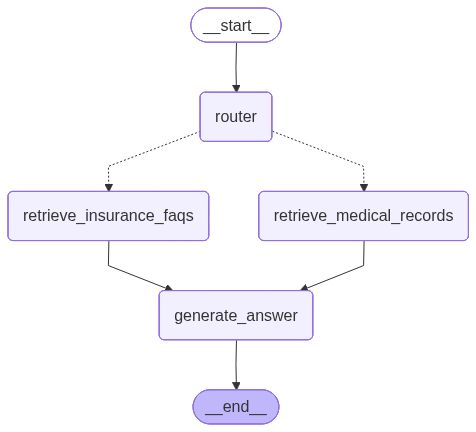

In [ ]:
from typing import Annotated, Literal, TypedDict

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_ollama import OllamaEmbeddings 

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages

embeddings =OllamaEmbeddings(model="nomic-embed-text")
# berguna untuk menghasilkan kueri SQL
model_low_temp = ChatOpenAI(model=default_model_name,temperature=0.1)
# berguna untuk menghasilkan keluaran bahasa alami
model_high_temp = ChatOpenAI(model=default_model_name,temperature=0.7)

class State(TypedDict):
    # untuk melacak riwayat percakapan
    messages: Annotated[list, add_messages]
    # masukan
    user_query: str
    # keluaran
    domain: Literal["records", "insurance"]
    documents: list[Document]
    answer: str

class Input(TypedDict):
    user_query: str

class Output(TypedDict):
    documents: list[Document]
    answer: str

# lihat Bab 2 tentang cara mengisi toko vektor dengan dokumen
medical_records_store = InMemoryVectorStore.from_documents([], embeddings)
medical_records_retriever = medical_records_store.as_retriever()

insurance_faqs_store = InMemoryVectorStore.from_documents([], embeddings)
insurance_faqs_retriever = insurance_faqs_store.as_retriever()

router_prompt = SystemMessage(
    """Anda perlu memutuskan domain mana untuk mengarahkan kueri pengguna. Anda memiliki dua
        domain untuk dipilih:
          - records: berisi catatan medis pasien, seperti
          diagnosis, perawatan, dan resep.
          - insurance: berisi pertanyaan yang sering diajukan tentang asuransi
          kebijakan, klaim, dan cakupan.

Keluarkan hanya nama domain."""
)

def router_node(state: State) -> State:
    user_message = HumanMessage(state["user_query"])
    messages = [router_prompt, *state["messages"], user_message]
    res = model_low_temp.invoke(messages)
    return {
        "domain": res.content,
        # perbarui riwayat percakapan
        "messages": [user_message, res],
    }

def pick_retriever(
    state: State,
) -> Literal["retrieve_medical_records", "retrieve_insurance_faqs"]:
    if state["domain"] == "records":
        return "retrieve_medical_records"
    else:
        return "retrieve_insurance_faqs"

def retrieve_medical_records(state: State) -> State:
    documents = medical_records_retriever.invoke(state["user_query"])
    return {
        "documents": documents,
    }

def retrieve_insurance_faqs(state: State) -> State:
    documents = insurance_faqs_retriever.invoke(state["user_query"])
    return {
        "documents": documents,
    }

medical_records_prompt = SystemMessage(
    """Anda adalah chatbot medis yang membantu yang menjawab pertanyaan berdasarkan
        catatan medis pasien, seperti diagnosis, perawatan, dan
        resep."""
)

insurance_faqs_prompt = SystemMessage(
    """Anda adalah chatbot asuransi medis yang membantu yang menjawab pertanyaan yang sering diajukan
        tentang kebijakan asuransi, klaim, dan cakupan."""
)

def generate_answer(state: State) -> State:
    if state["domain"] == "records":
        prompt = medical_records_prompt
    else:
        prompt = insurance_faqs_prompt
    messages = [
        prompt,
        *state["messages"],
        HumanMessage(f"Dokumen: {state['documents']}"),
    ]
    res = model_high_temp.invoke(messages)
    return {
        "answer": res.content,
        # perbarui riwayat percakapan
        "messages": res,
    }

builder = StateGraph(State, input=Input, output=Output)
builder.add_node("router", router_node)
builder.add_node("retrieve_medical_records", retrieve_medical_records)
builder.add_node("retrieve_insurance_faqs", retrieve_insurance_faqs)
builder.add_node("generate_answer", generate_answer)
builder.add_edge(START, "router")
builder.add_conditional_edges("router", pick_retriever)
builder.add_edge("retrieve_medical_records", "generate_answer")
builder.add_edge("retrieve_insurance_faqs", "generate_answer")
builder.add_edge("generate_answer", END)

graph = builder.compile()
png_bytes =graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))

In [20]:
input = {
    "user_query": "Apakah saya dicakup untuk perawatan COVID-19?"
}
for c in graph.stream(input):
    print(c)

{'router': {'domain': 'insurance', 'messages': [HumanMessage(content='Apakah saya dicakup untuk perawatan COVID-19?', id='e6e18ce7-d1cf-4e12-9a7e-f07af2536eb6'), AIMessage(content='insurance', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 125, 'total_tokens': 126, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'qwen3-coder-plus', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-3c57fac2-4c29-47a2-84b8-b97b18ea6a81-0', usage_metadata={'input_tokens': 125, 'output_tokens': 1, 'total_tokens': 126})]}}
{'retrieve_insurance_faqs': {'documents': []}}
{'generate_answer': {'answer': 'Ya, sebagian besar rencana asuransi kesehatan mencakup perawatan untuk COVID-19, termasuk pengujian (testing), vaksinasi, dan perawatan medis yang terkait. Cakupan spesifik dapat bervariasi tergantung pada jenis rencana asuransi Anda.\n\nBerikut a